# Superior temporal gyrus (POSTERIOR COPE)

## Contrast Sentences

In [1]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe1 = pd.read_csv(
    "roi_activation_cope1.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe1 = participants.merge(
    pe1,
    on="participant_id",
    how="inner"
)

merged_pe1.to_csv("merged_pe1.csv", index=False)

print(merged_pe1.head())

  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       64.021598
1         sub-02   36    male  104    HC      NaN       10.967116
2         sub-03   43    male  108    HC      NaN       62.640775
3         sub-04   25    male  106    HC      NaN       87.414646
4         sub-05   52  female  102    HC      NaN       42.478478


In [104]:
merged_pe1[merged_pe1['group'] == 'HC'].shape[0]

25

In [ ]:
merged_pe1[merged_pe1['group'] == 'HC'].shape[0]

23

In [106]:
merged_pe1[merged_pe1['group'] == 'AVH-'].shape[0]

23

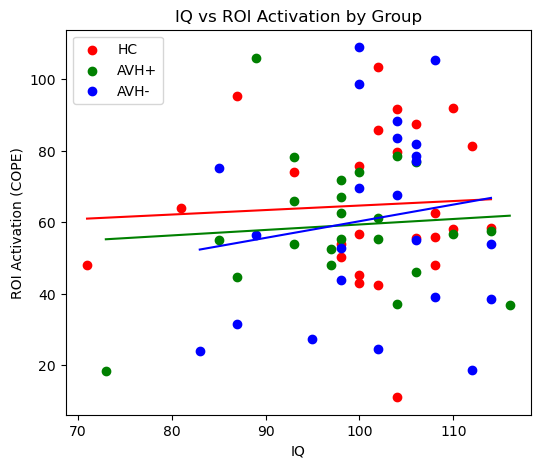

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe1[merged_pe1["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


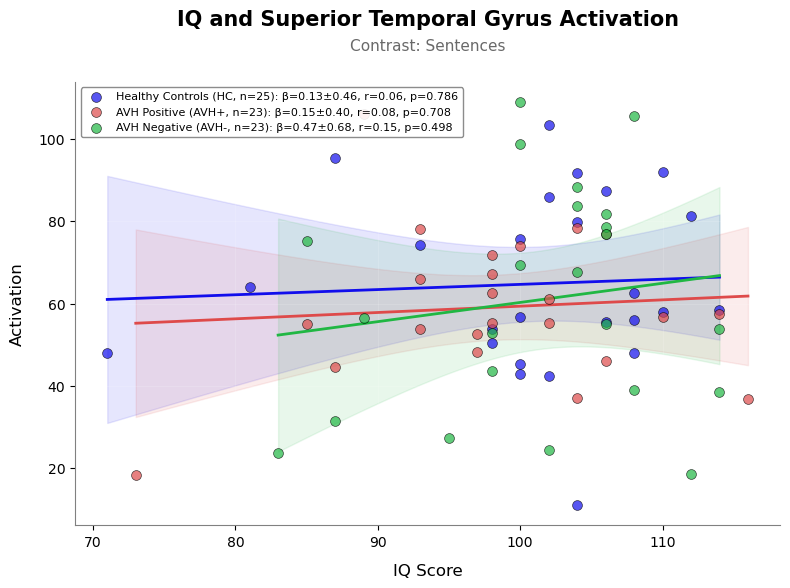

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

groups = {
    "HC":   {"color": "#110eec", "label": "Healthy Controls"},
    "AVH+": {"color": "#de4a4a", "label": "AVH Positive"},
    "AVH-": {"color": "#20b743", "label": "AVH Negative"},
}

for g, conf in groups.items():
    subset = merged_pe1[merged_pe1["group"] == g].copy()
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    if len(subset) < 3 or subset["iq"].nunique() < 2:
        continue

    x = subset["iq"].to_numpy()
    y = subset["roi_activation"].to_numpy()
    n = len(x)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    ax.scatter(x, y, color=conf["color"], alpha=0.7, s=50, edgecolors='black',
               linewidths=0.5, zorder=3,
               label=f'{conf["label"]} ({g}, n={n}): β={slope:.2f}±{std_err:.2f}, r={r_value:.2f}, p={p_value:.3f}')

    xs = np.linspace(x.min(), x.max(), 200)
    y_hat = slope * xs + intercept

    
    x_mean = x.mean()
    se_fit = np.sqrt(
        (np.sum((y - (slope*x + intercept))**2) / (n - 2))
        * (1/n + (xs - x_mean)**2 / np.sum((x - x_mean)**2))
    )
    t_crit = stats.t.ppf(0.975, df=n-2)

    ax.fill_between(xs, y_hat - t_crit*se_fit, y_hat + t_crit*se_fit,
                     color=conf["color"], alpha=0.1, zorder=1)
    ax.plot(xs, y_hat, color=conf["color"], linewidth=2, zorder=2)

ax.set_xlabel("IQ Score", fontsize=12, color='black', labelpad=10)
ax.set_ylabel("Activation", fontsize=12, color='black', labelpad=10)
ax.set_title("IQ and Superior Temporal Gyrus Activation", fontsize=15, color='black', pad=15, fontweight='bold', y=1.08)
ax.text(
    0.5, 1.07,
    "Contrast: Sentences",
    transform=ax.transAxes,
    ha="center",
    fontsize=11,
    color="dimgray"
)

ax.tick_params(colors='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.grid(True, alpha=0.15)

legend = ax.legend(fontsize=8, loc='upper left', frameon=True, facecolor='white',
                   edgecolor='gray', framealpha=0.9)
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.savefig("iq_vs_roi_scatter.png", dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

Based on your actual results:

**Healthy Controls (HC):** β = 0.13 ± 0.46, R² = 0.003, p = 0.786

The slope is nearly flat (0.13) with a large SE (0.46) — the SE is 3.5x bigger than the slope itself, meaning the estimate is very imprecise. R² = 0.003 means IQ explains only 0.3% of the variance in ROI activation. p = 0.786 is far from significant. **No meaningful relationship between IQ and ROI activation in healthy controls.**

**AVH Positive (AVH+):** β = 0.15 ± 0.40, R² = 0.007, p = 0.708

Very similar story — a near-zero slope (0.15) with a large SE (0.40). R² = 0.007 means IQ explains less than 1% of variance. p = 0.708 is not significant. **No meaningful relationship in the AVH+ group either.**

**AVH Negative (AVH-):** β = 0.47 ± 0.68, R² = 0.022, p = 0.498

This group has the steepest slope (0.47), but the SE is even larger (0.68), so it's still unreliable. R² = 0.022 means only 2.2% of variance explained — slightly more than the other groups but still very weak. p = 0.498 is not significant. **No meaningful relationship here either, despite the slightly steeper trend.**

**Overall takeaway:** None of the three groups show a statistically significant linear relationship between IQ and ROI activation. The slopes are all small, the standard errors are large relative to the slopes, R² values are near zero, and all p-values are well above 0.05. IQ does not appear to predict ROI activation in any group in this dataset.

## Words

In [3]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe3 = pd.read_csv(
    "roi_activation_cope3.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe3 = participants.merge(
    pe3,
    on="participant_id",
    how="inner"
)

merged_pe3.to_csv("merged_pe3.csv", index=False)

print(merged_pe3.head())

  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       60.519567
1         sub-02   36    male  104    HC      NaN       13.533142
2         sub-03   43    male  108    HC      NaN       44.950672
3         sub-04   25    male  106    HC      NaN       57.103496
4         sub-05   52  female  102    HC      NaN       48.664822


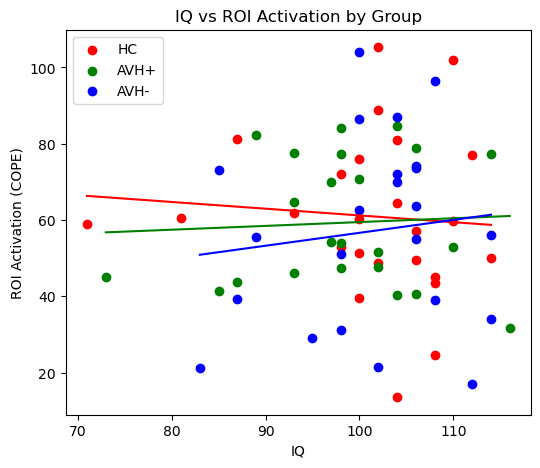

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe3[merged_pe3["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


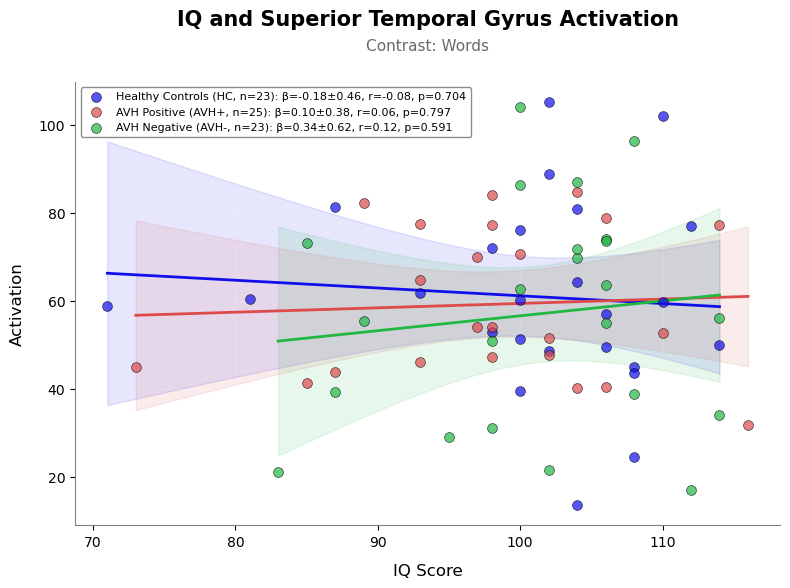

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

groups = {
    "HC":   {"color": "#110eec", "label": "Healthy Controls"},
    "AVH+": {"color": "#de4a4a", "label": "AVH Positive"},
    "AVH-": {"color": "#20b743", "label": "AVH Negative"},
}

for g, conf in groups.items():
    subset = merged_pe3[merged_pe3["group"] == g].copy()
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    if len(subset) < 3 or subset["iq"].nunique() < 2:
        continue

    x = subset["iq"].to_numpy()
    y = subset["roi_activation"].to_numpy()

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    ax.scatter(x, y, color=conf["color"], alpha=0.7, s=50, edgecolors='black',
               linewidths=0.5, zorder=3,
               label=f'{conf["label"]} ({g}, n={n}): β={slope:.2f}±{std_err:.2f}, r={r_value:.2f}, p={p_value:.3f}')

    xs = np.linspace(x.min(), x.max(), 200)
    y_hat = slope * xs + intercept

    n = len(x)
    x_mean = x.mean()
    se_fit = np.sqrt(
        (np.sum((y - (slope*x + intercept))**2) / (n - 2))
        * (1/n + (xs - x_mean)**2 / np.sum((x - x_mean)**2))
    )
    t_crit = stats.t.ppf(0.975, df=n-2)

    ax.fill_between(xs, y_hat - t_crit*se_fit, y_hat + t_crit*se_fit,
                     color=conf["color"], alpha=0.1, zorder=1)
    ax.plot(xs, y_hat, color=conf["color"], linewidth=2, zorder=2)

ax.set_xlabel("IQ Score", fontsize=12, color='black', labelpad=10)
ax.set_ylabel("Activation", fontsize=12, color='black', labelpad=10)
ax.set_title("IQ and Superior Temporal Gyrus Activation", fontsize=15, color='black', pad=15, fontweight='bold', y=1.08)
ax.text(
    0.5, 1.07,
    "Contrast: Words",
    transform=ax.transAxes,
    ha="center",
    fontsize=11,
    color="dimgray"
)

ax.tick_params(colors='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.grid(True, alpha=0.15)

legend = ax.legend(fontsize=8, loc='upper left', frameon=True, facecolor='white',
                   edgecolor='gray', framealpha=0.9)
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.savefig("iq_vs_roi_scatter.png", dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Reversed

In [5]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe5 = pd.read_csv(
    "roi_activation_cope5.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe5 = participants.merge(
    pe5,
    on="participant_id",
    how="inner"
)

merged_pe5.to_csv("merged_pe5.csv", index=False)

print(merged_pe5.head())

  participant_id  age     sex   iq group  psyrats roi_activation
0         sub-01   47    male   81    HC      NaN     82.956673 
1         sub-02   36    male  104    HC      NaN     -7.816308 
2         sub-03   43    male  108    HC      NaN     69.724218 
3         sub-04   25    male  106    HC      NaN     92.857690 
4         sub-05   52  female  102    HC      NaN     54.252527 


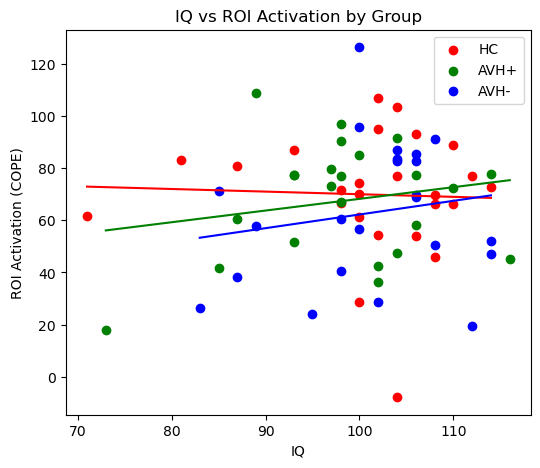

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe5[merged_pe5["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


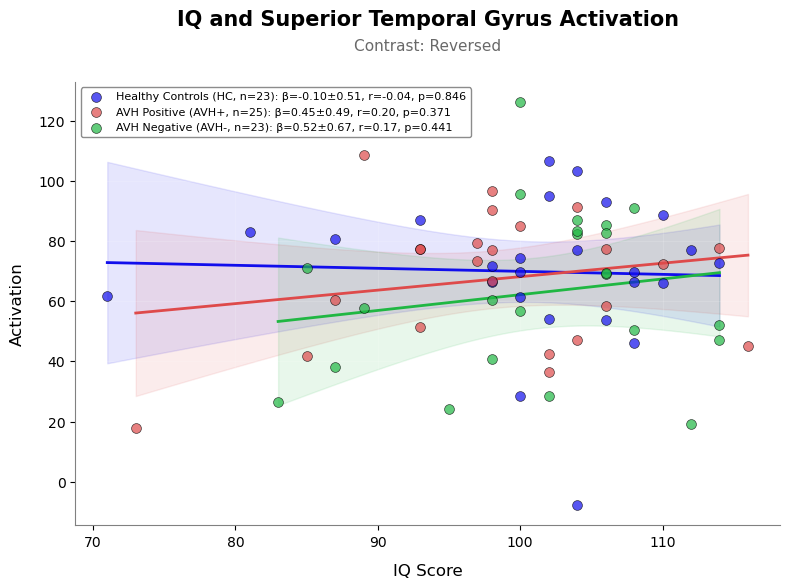

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

groups = {
    "HC":   {"color": "#110eec", "label": "Healthy Controls"},
    "AVH+": {"color": "#de4a4a", "label": "AVH Positive"},
    "AVH-": {"color": "#20b743", "label": "AVH Negative"},
}

for g, conf in groups.items():
    subset = merged_pe5[merged_pe5["group"] == g].copy()
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    if len(subset) < 3 or subset["iq"].nunique() < 2:
        continue

    x = subset["iq"].to_numpy()
    y = subset["roi_activation"].to_numpy()

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    ax.scatter(x, y, color=conf["color"], alpha=0.7, s=50, edgecolors='black',
               linewidths=0.5, zorder=3,
               label=f'{conf["label"]} ({g}, n={n}): β={slope:.2f}±{std_err:.2f}, r={r_value:.2f}, p={p_value:.3f}')

    xs = np.linspace(x.min(), x.max(), 200)
    y_hat = slope * xs + intercept

    n = len(x)
    x_mean = x.mean()
    se_fit = np.sqrt(
        (np.sum((y - (slope*x + intercept))**2) / (n - 2))
        * (1/n + (xs - x_mean)**2 / np.sum((x - x_mean)**2))
    )
    t_crit = stats.t.ppf(0.975, df=n-2)

    ax.fill_between(xs, y_hat - t_crit*se_fit, y_hat + t_crit*se_fit,
                     color=conf["color"], alpha=0.1, zorder=1)
    ax.plot(xs, y_hat, color=conf["color"], linewidth=2, zorder=2)

ax.set_xlabel("IQ Score", fontsize=12, color='black', labelpad=10)
ax.set_ylabel("Activation", fontsize=12, color='black', labelpad=10)
ax.set_title("IQ and Superior Temporal Gyrus Activation", fontsize=15, color='black', pad=15, fontweight='bold', y=1.08)
ax.text(
    0.5, 1.07,
    "Contrast: Reversed",
    transform=ax.transAxes,
    ha="center",
    fontsize=11,
    color="dimgray"
)

ax.tick_params(colors='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.grid(True, alpha=0.15)

legend = ax.legend(fontsize=8, loc='upper left', frameon=True, facecolor='white',
                   edgecolor='gray', framealpha=0.9)
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.savefig("iq_vs_roi_scatter.png", dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

HC
  Pearson r = -0.041, p = 0.846
  Spearman r = -0.042, p = 0.842
AVH+
  Pearson r = 0.195, p = 0.371
  Spearman r = 0.052, p = 0.815
AVH-
  Pearson r = 0.169, p = 0.441
  Spearman r = 0.133, p = 0.545


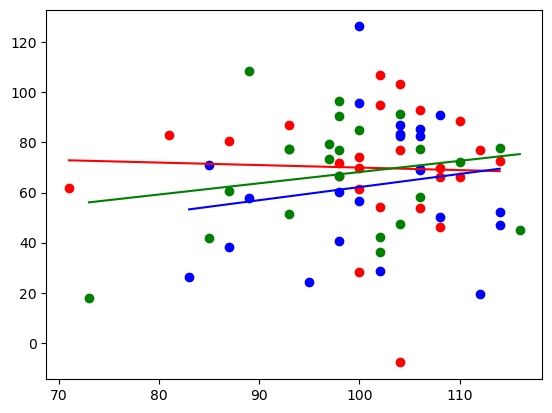

In [7]:
from scipy.stats import pearsonr, spearmanr

for g, color in groups.items():
    subset = merged_pe5[merged_pe5["group"] == g].copy()

    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    plt.scatter(subset["iq"], subset["roi_activation"], label=g, color=color)

    if len(subset) >= 3:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        # regression line
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

        # correlations
        r_p, p_p = pearsonr(x, y)
        r_s, p_s = spearmanr(x, y)

        print(f"{g}")
        print(f"  Pearson r = {r_p:.3f}, p = {p_p:.3f}")
        print(f"  Spearman r = {r_s:.3f}, p = {p_s:.3f}")


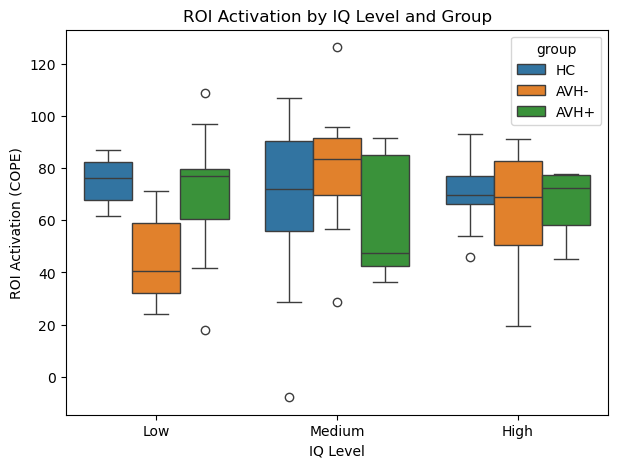

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = merged_pe5.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# create 3 IQ levels
df["IQ_level"] = pd.qcut(df["iq"], q=3, labels=["Low", "Medium", "High"])

plt.figure(figsize=(7,5))

sns.boxplot(
    data=df,
    x="IQ_level",
    y="roi_activation",
    hue="group"
)

plt.xlabel("IQ Level")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Level and Group")
plt.show()


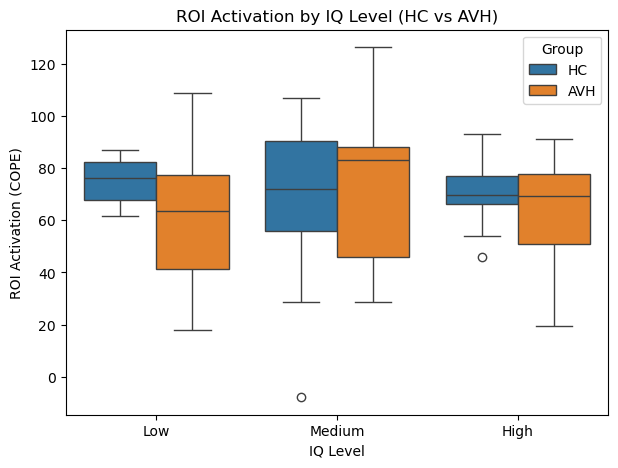

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = merged_pe5.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# combine AVH+ and AVH-
df["group_combined"] = df["group"].replace({
    "AVH+": "AVH",
    "AVH-": "AVH"
})

# create 3 IQ levels
df["IQ_level"] = pd.qcut(df["iq"], q=3, labels=["Low", "Medium", "High"])

plt.figure(figsize=(7,5))

sns.boxplot(
    data=df,
    x="IQ_level",
    y="roi_activation",
    hue="group_combined"
)


plt.xlabel("IQ Level")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Level (HC vs AVH)")
plt.legend(title="Group")
plt.show()


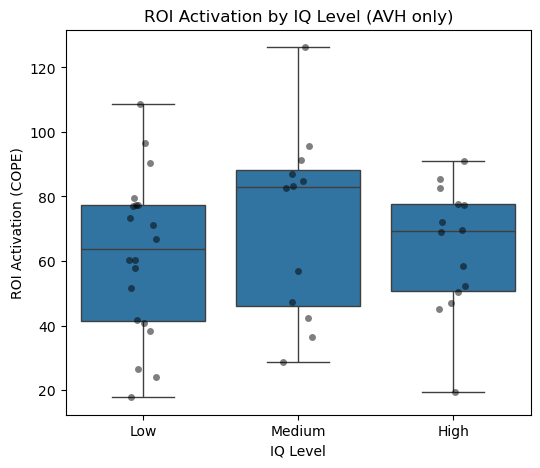

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = merged_pe5.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# keep only AVH subjects (both AVH+ and AVH-)
df_avh = df[df["group"].isin(["AVH+", "AVH-"])].copy()

# create IQ levels
df_avh["IQ_level"] = pd.qcut(df_avh["iq"], q=3, labels=["Low", "Medium", "High"])

plt.figure(figsize=(6,5))

sns.boxplot(
    data=df_avh,
    x="IQ_level",
    y="roi_activation"
)

# optional: show individual points
sns.stripplot(
    data=df_avh,
    x="IQ_level",
    y="roi_activation",
    color="black",
    alpha=0.5
)

plt.xlabel("IQ Level")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Level (AVH only)")
plt.show()


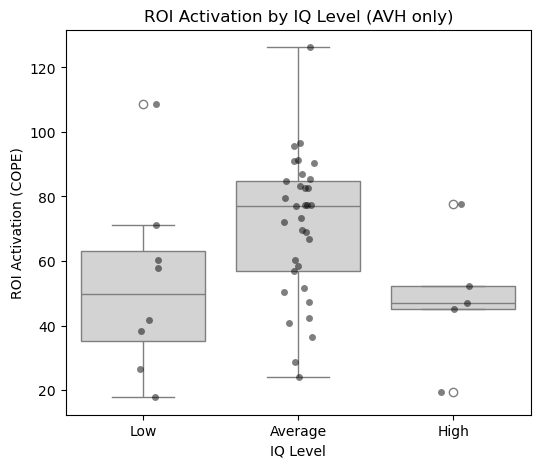

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = merged_pe5.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# keep only AVH subjects
df = df[df["group"].isin(["AVH+", "AVH-"])]

# fixed IQ categories
df["IQ_level"] = pd.cut(
    df["iq"],
    bins=[0, 90, 110, 200],
    labels=["Low", "Average", "High"]
)

# remove any rows outside bins
df = df.dropna(subset=["IQ_level"])

plt.figure(figsize=(6,5))

sns.boxplot(
    data=df,
    x="IQ_level",
    y="roi_activation",
    color="lightgray"
)

sns.stripplot(
    data=df,
    x="IQ_level",
    y="roi_activation",
    color="black",
    alpha=0.5
)

plt.xlabel("IQ Level")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Level (AVH only)")
plt.show()


In [12]:
merged_pe5

,participant_id,age,sex,iq,group,psyrats,roi_activation
0,sub-01,47,male,81,HC,NaN,82.956673
1,sub-02,36,male,104,HC,NaN,-7.816308
2,sub-03,43,male,108,HC,NaN,69.724218
3,sub-04,25,male,106,HC,NaN,92.857690
4,sub-05,52,female,102,HC,NaN,54.252527
...,...,...,...,...,...,...,...
66,sub-73,20,female,73,AVH+,29.0,17.768686
67,sub-74,42,male,114,AVH+,34.0,77.755453
68,sub-75,32,male,98,AVH+,30.0,90.452572
69,sub-76,39,male,98,AVH+,21.0,96.693600


<Axes: xlabel='IQ_level', ylabel='roi_activation'>

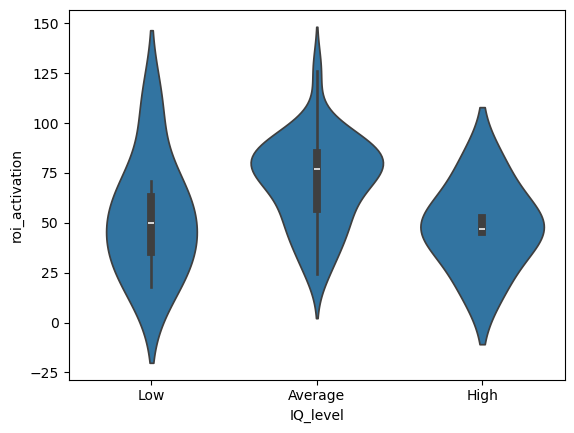

In [13]:
sns.violinplot(
    data=df,
    x="IQ_level",
    y="roi_activation",
    inner="box"
)


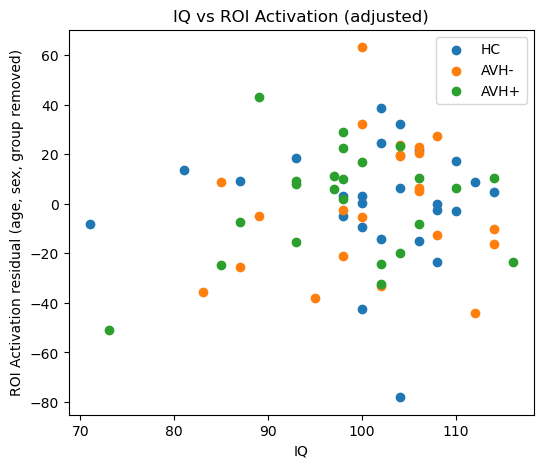

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df = merged_pe5.copy()
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation", "age", "sex", "group"])

# encode sex
df["sex_bin"] = (df["sex"].str.lower() == "male").astype(int)

# residualize ROI on age, sex, group
X = pd.get_dummies(df[["age", "sex_bin", "group"]], drop_first=True)
y = df["roi_activation"].to_numpy()
model = LinearRegression().fit(X, y)
df["roi_resid"] = y - model.predict(X)

plt.figure(figsize=(6,5))
for g in df["group"].unique():
    sub = df[df["group"] == g]
    plt.scatter(sub["iq"], sub["roi_resid"], label=g)

plt.xlabel("IQ")
plt.ylabel("ROI Activation residual (age, sex, group removed)")
plt.title("IQ vs ROI Activation (adjusted)")
plt.legend()
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_75361/2726367870.py:17: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df, x="IQ_level", y="roi_activation", hue="group", dodge=True, alpha=0.35, color="black")


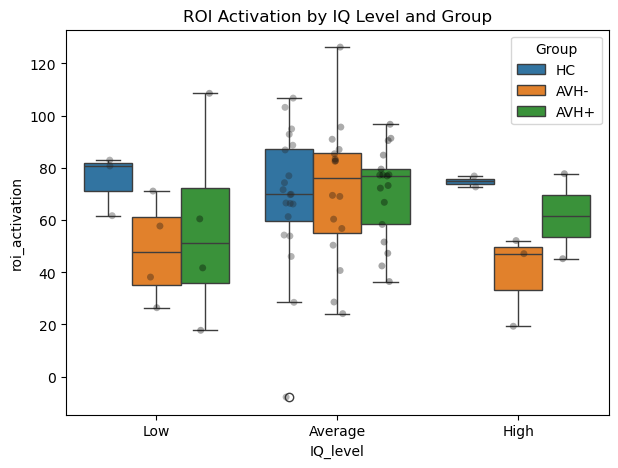

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

df = merged_pe5.copy()
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation", "group"])

df["IQ_level"] = pd.cut(
    df["iq"],
    bins=[0, 90, 110, 200],
    labels=["Low", "Average", "High"]
)

plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="IQ_level", y="roi_activation", hue="group")
sns.stripplot(data=df, x="IQ_level", y="roi_activation", hue="group", dodge=True, alpha=0.35, color="black")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(df["group"].unique())], labels[:len(df["group"].unique())], title="Group")
plt.title("ROI Activation by IQ Level and Group")
plt.show()


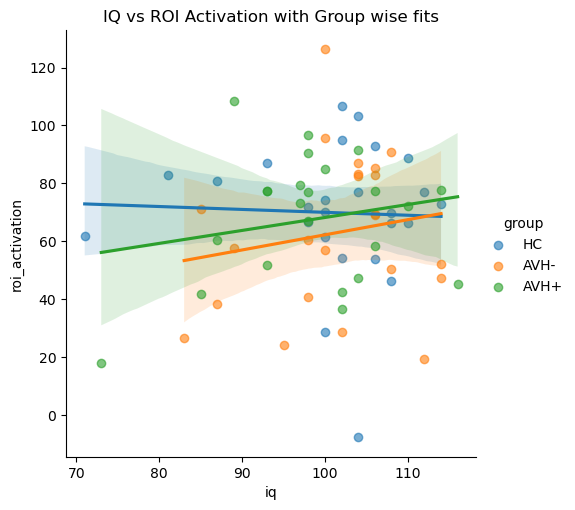

In [16]:
import seaborn as sns

df = merged_pe5.copy()
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation", "group"])

sns.lmplot(
    data=df,
    x="iq",
    y="roi_activation",
    hue="group",
    height=5,
    scatter_kws={"alpha":0.6}
)
plt.title("IQ vs ROI Activation with Group wise fits")
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_75361/3262295167.py:30: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


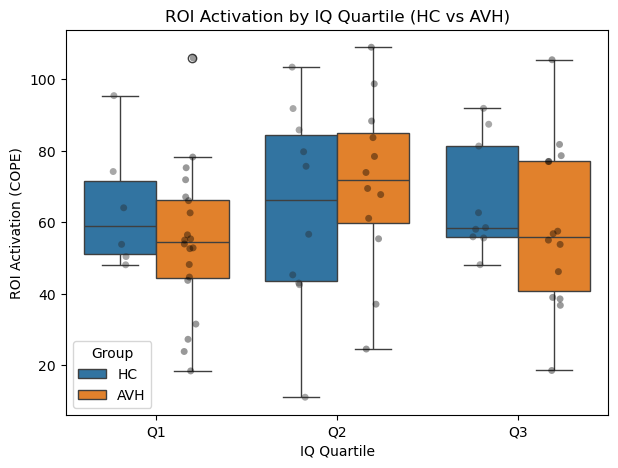

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = merged_pe1.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# combine AVH groups
df["group_combined"] = df["group"].replace({
    "AVH+": "AVH",
    "AVH-": "AVH"
})

# create IQ quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=3, labels=["Q1","Q2","Q3"])

plt.figure(figsize=(7,5))

sns.boxplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined"
)

sns.stripplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined",
    dodge=True,
    alpha=0.4,
    color="black"
)

# fix duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Group")

plt.xlabel("IQ Quartile")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Quartile (HC vs AVH)")
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_75361/1240971931.py:30: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


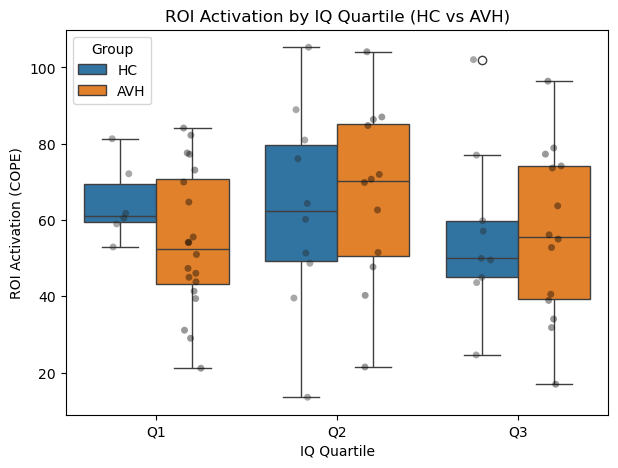

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = merged_pe3.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# combine AVH groups
df["group_combined"] = df["group"].replace({
    "AVH+": "AVH",
    "AVH-": "AVH"
})

# create IQ quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=3, labels=["Q1","Q2","Q3"])

plt.figure(figsize=(7,5))

sns.boxplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined"
)

sns.stripplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined",
    dodge=True,
    alpha=0.4,
    color="black"
)

# fix duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Group")

plt.xlabel("IQ Quartile")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Quartile (HC vs AVH)")
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_75361/3263419226.py:30: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


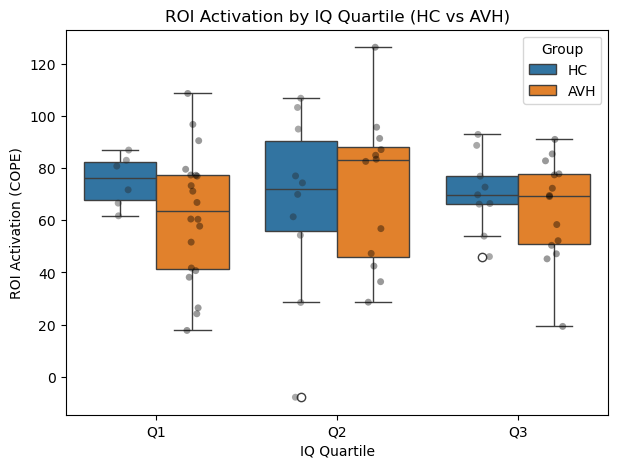

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = merged_pe5.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# combine AVH groups
df["group_combined"] = df["group"].replace({
    "AVH+": "AVH",
    "AVH-": "AVH"
})

# create IQ quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=3, labels=["Q1","Q2","Q3"])

plt.figure(figsize=(7,5))

sns.boxplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined"
)

sns.stripplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined",
    dodge=True,
    alpha=0.4,
    color="black"
)

# fix duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Group")

plt.xlabel("IQ Quartile")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Quartile (HC vs AVH)")
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_75361/4067359818.py:20: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  avh_extreme["IQ_group"] = avh_extreme["iq_quartile"].replace({


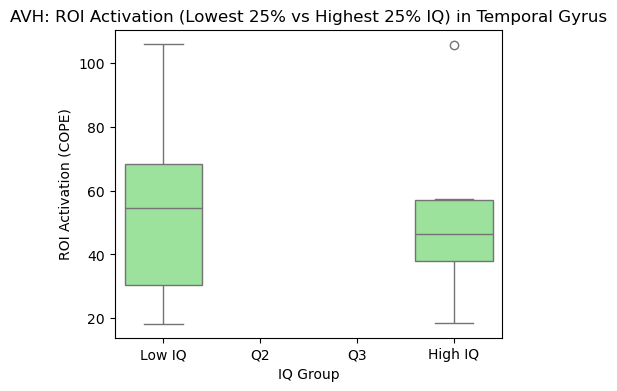

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# keep only AVH
avh = merged_pe1[merged_pe1["group"].isin(["AVH+","AVH-"])].copy()

# clean
avh["iq"] = pd.to_numeric(avh["iq"], errors="coerce")
avh["roi_activation"] = pd.to_numeric(avh["roi_activation"], errors="coerce")
avh = avh.dropna(subset=["iq","roi_activation"])

# compute quartiles within AVH only
avh["iq_quartile"] = pd.qcut(avh["iq"], q=4, labels=["Q1","Q2","Q3","Q4"])

# keep lowest and highest quartiles only
avh_extreme = avh[avh["iq_quartile"].isin(["Q1","Q4"])].copy()

# rename for clarity
avh_extreme["IQ_group"] = avh_extreme["iq_quartile"].replace({
    "Q1": "Low IQ",
    "Q4": "High IQ"
})

plt.figure(figsize=(5,4))

sns.boxplot(
    data=avh_extreme,
    x="IQ_group",
    y="roi_activation",
    color="lightgreen"
)

# sns.stripplot(
#     data=avh_extreme,
#     x="IQ_group",
#     y="roi_activation",
#     color="black",
#     alpha=0.5
# )

plt.title("AVH: ROI Activation (Lowest 25% vs Highest 25% IQ) in Temporal Gyrus")
plt.xlabel("IQ Group")
plt.ylabel("ROI Activation (COPE)")
plt.show()


# Auditory Cortex Left

In [21]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe1_audit = pd.read_csv(
    "roi_activation_audit_left_cope1.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe1_audit = participants.merge(
    pe1_audit,
    on="participant_id",
    how="inner"
)

merged_pe1_audit.to_csv("merged_pe1_audit.csv", index=False)

print(merged_pe1_audit.head())

  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       63.791620
1         sub-02   36    male  104    HC      NaN       17.349418
2         sub-03   43    male  108    HC      NaN       53.056535
3         sub-04   25    male  106    HC      NaN      130.514411
4         sub-05   52  female  102    HC      NaN       13.345386


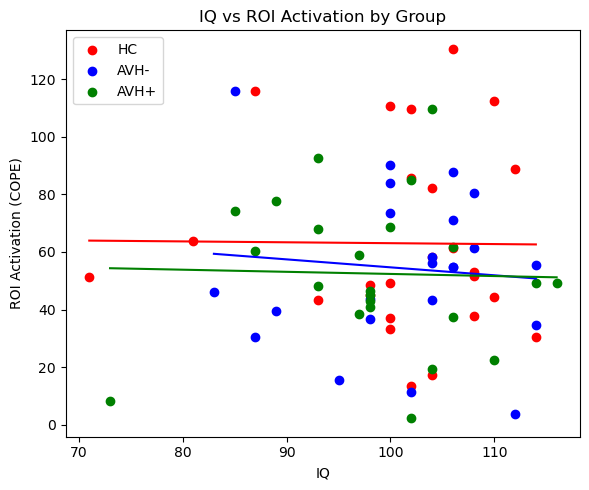

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = merged_pe1_audit.copy()

# clean
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq","roi_activation","group"])

groups = {
    "HC": "red",
    "AVH-": "blue",
    "AVH+": "green"
}

plt.figure(figsize=(6,5))

for g, color in groups.items():
    sub = df[df["group"] == g]

    plt.scatter(sub["iq"], sub["roi_activation"], label=g, color=color)

    if len(sub) >= 2 and sub["iq"].nunique() >= 2:
        x = sub["iq"].to_numpy()
        y = sub["roi_activation"].to_numpy()
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_75361/3220700823.py:30: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


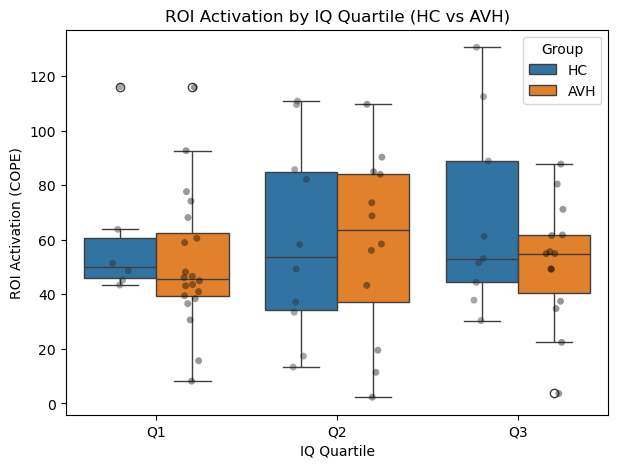

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = merged_pe1_audit.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# combine AVH groups
df["group_combined"] = df["group"].replace({
    "AVH+": "AVH",
    "AVH-": "AVH"
})

# create IQ quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=3, labels=["Q1","Q2","Q3"])

plt.figure(figsize=(7,5))

sns.boxplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined"
)

sns.stripplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined",
    dodge=True,
    alpha=0.4,
    color="black"
)

# fix duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Group")

plt.xlabel("IQ Quartile")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Quartile (HC vs AVH)")
plt.show()


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = merged_pe3_audit.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# combine AVH groups
df["group_combined"] = df["group"].replace({
    "AVH+": "AVH",
    "AVH-": "AVH"
})

# create IQ quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=3, labels=["Q1","Q2","Q3"])

plt.figure(figsize=(7,5))

sns.boxplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined"
)

sns.stripplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined",
    dodge=True,
    alpha=0.4,
    color="black"
)

# fix duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Group")

plt.xlabel("IQ Quartile")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Quartile (HC vs AVH)")
plt.show()


NameError: name 'merged_pe3_audit' is not defined

/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/1233868338.py:30: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


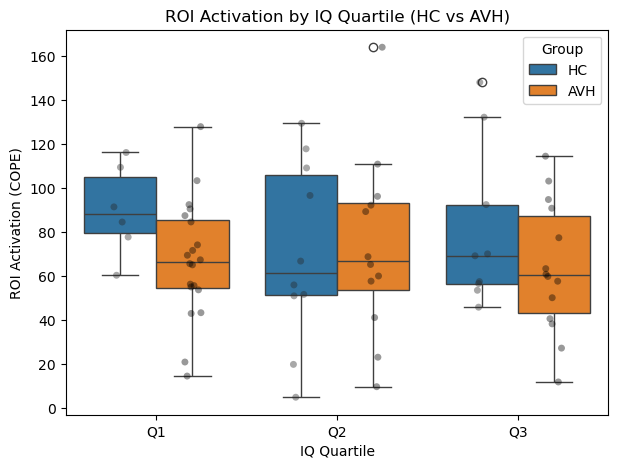

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = merged_pe5_audit.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# combine AVH groups
df["group_combined"] = df["group"].replace({
    "AVH+": "AVH",
    "AVH-": "AVH"
})

# create IQ quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=3, labels=["Q1","Q2","Q3"])

plt.figure(figsize=(7,5))

sns.boxplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined"
)

sns.stripplot(
    data=df,
    x="iq_quartile",
    y="roi_activation",
    hue="group_combined",
    dodge=True,
    alpha=0.4,
    color="black"
)

# fix duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Group")

plt.xlabel("IQ Quartile")
plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by IQ Quartile (HC vs AVH)")
plt.show()


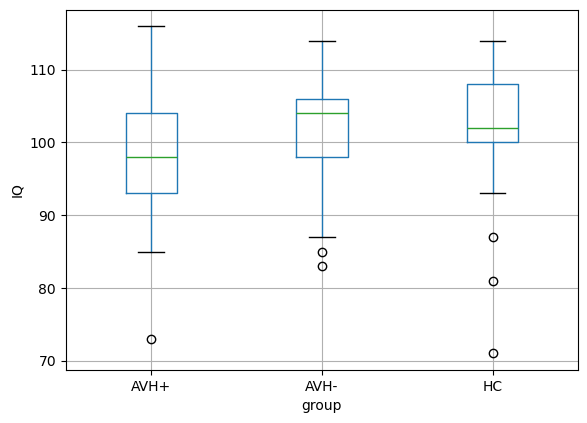

In [ ]:
df.boxplot(column="iq", by="group")
plt.title("")
plt.suptitle("")
plt.ylabel("IQ")
plt.show()


AVH- correlation (r): -0.089
AVH+ correlation (r): -0.027


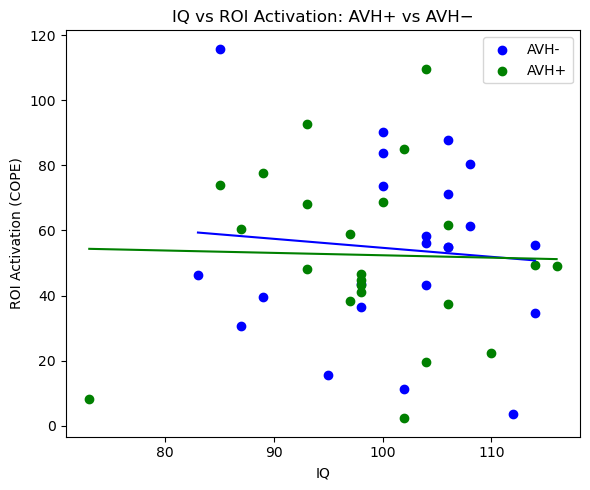

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = merged_pe1_audit.copy()

# keep only AVH groups
df = df[df["group"].isin(["AVH+", "AVH-"])].copy()

# clean
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq","roi_activation","group"])

groups = {
    "AVH-": "blue",
    "AVH+": "green"
}

plt.figure(figsize=(6,5))

for g, color in groups.items():
    sub = df[df["group"] == g]

    # scatter
    plt.scatter(sub["iq"], sub["roi_activation"], label=g, color=color)

    # regression + correlation
    if len(sub) >= 2 and sub["iq"].nunique() >= 2:
        x = sub["iq"].to_numpy()
        y = sub["roi_activation"].to_numpy()

        # regression line
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

        # correlation
        r = np.corrcoef(x, y)[0,1]
        print(f"{g} correlation (r): {r:.3f}")

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation: AVH+ vs AVH−")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
for g in df["group"].unique():
    sub = df[df["group"] == g]
    print(g, sub[["age","roi_activation"]].corr().iloc[0,1])


HC -0.33225446135179476
AVH- -0.12091759668487669
AVH+ -0.23928690037674896


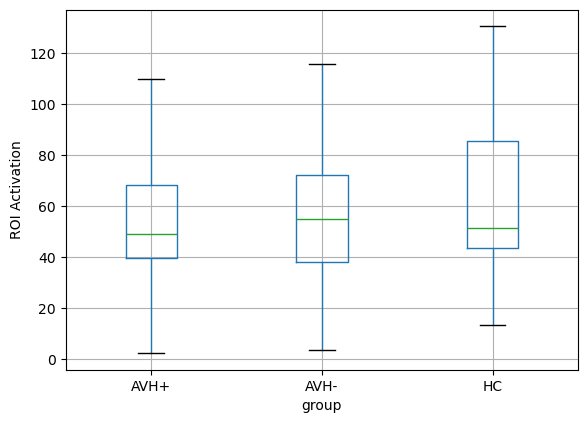

In [ ]:
merged_pe1_audit.boxplot(column="roi_activation", by="group")
plt.title("")
plt.suptitle("")
plt.ylabel("ROI Activation")
plt.show()


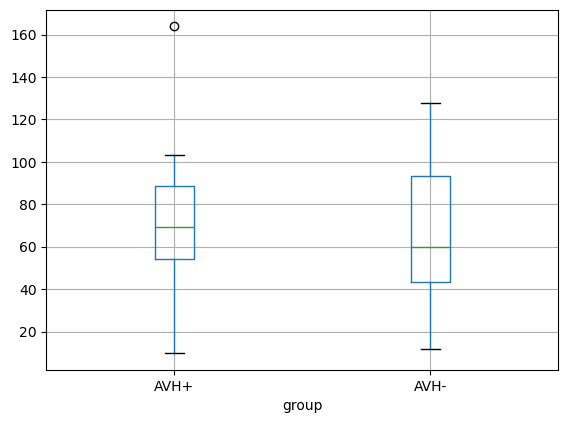

In [ ]:
df[df["group"]!="HC"].boxplot(column="roi_activation", by="group")
plt.title("")
plt.suptitle("")
plt.show()


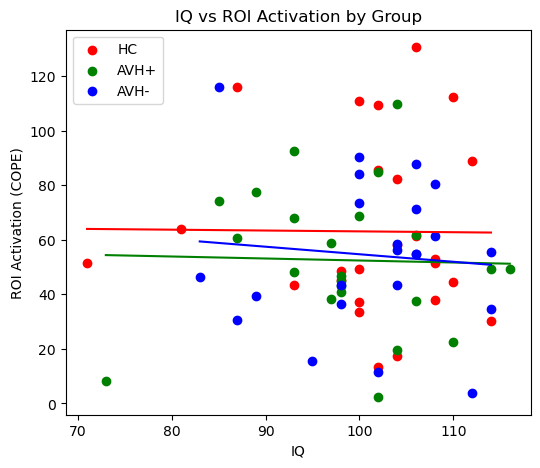

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe1_audit[merged_pe1_audit["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


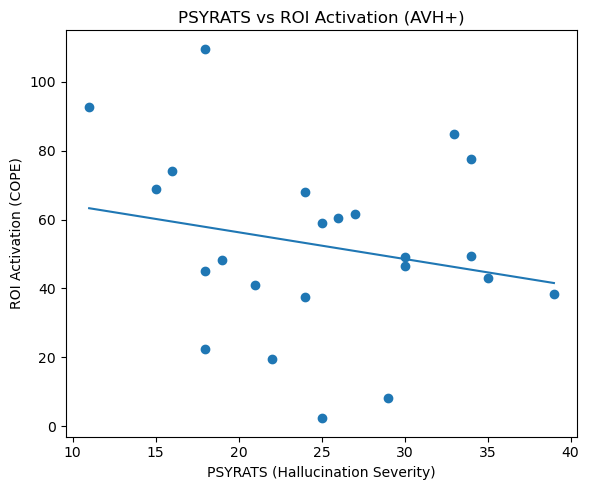

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = merged_pe1_audit.copy()

# keep AVH+ only (PSYRATS meaningful here)
df = df[df["group"] == "AVH+"].copy()

# clean columns
df["psyrats"] = pd.to_numeric(df["psyrats"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")

df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["psyrats", "roi_activation"])

# scatter plot
plt.figure(figsize=(6,5))
plt.scatter(df["psyrats"], df["roi_activation"])

# regression line
if len(df) >= 2 and df["psyrats"].nunique() >= 2:
    x = df["psyrats"].to_numpy()
    y = df["roi_activation"].to_numpy()
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, m*xs + b)

plt.xlabel("PSYRATS (Hallucination Severity)")
plt.ylabel("ROI Activation (COPE)")
plt.title("PSYRATS vs ROI Activation (AVH+)")
plt.tight_layout()
plt.show()


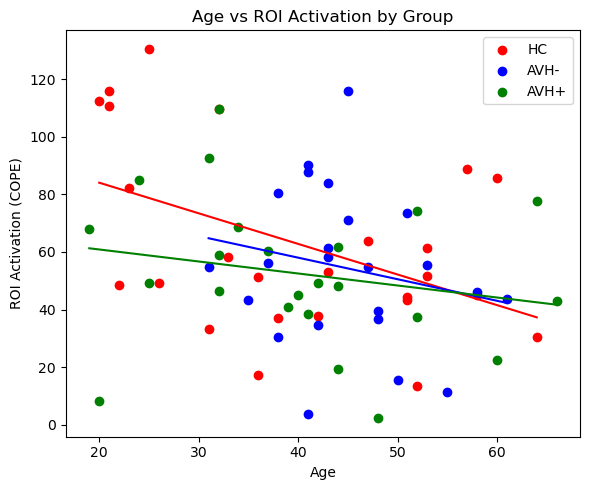

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = merged_pe1_audit.copy()

# clean columns
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["age", "roi_activation", "group"])

groups = {
    "HC": "red",
    "AVH-": "blue",
    "AVH+": "green"
}

plt.figure(figsize=(6,5))

for g, color in groups.items():
    subset = df[df["group"] == g]

    # scatter
    plt.scatter(
        subset["age"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line
    if len(subset) >= 2 and subset["age"].nunique() >= 2:
        x = subset["age"].to_numpy()
        y = subset["roi_activation"].to_numpy()
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m * xs + b, color=color)

plt.xlabel("Age")
plt.ylabel("ROI Activation (COPE)")
plt.title("Age vs ROI Activation by Group")
plt.legend()
plt.tight_layout()
plt.show()


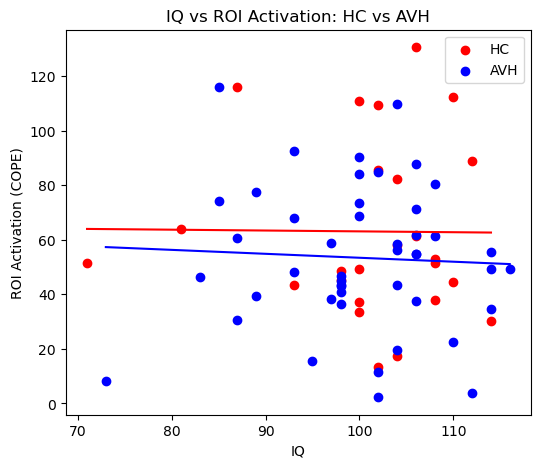

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

# Define new grouping
group_map = {
    "HC": "HC",
    "AVH+": "AVH",
    "AVH-": "AVH"
}

# Create a new column that merges AVH+ and AVH-
df = merged_pe1_audit.copy()
df["group_merged"] = df["group"].map(group_map)

groups = {
    "HC": "red",
    "AVH": "blue"
}

for g, color in groups.items():
    subset = df[df["group_merged"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation: HC vs AVH")
plt.legend()
plt.show()


In [ ]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe3_audit = pd.read_csv(
    "roi_activation_audit_left_cope3.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe3_audit = participants.merge(
    pe3_audit,
    on="participant_id",
    how="inner"
)

merged_pe3_audit.to_csv("merged_pe3_audit.csv", index=False)

print(merged_pe3_audit.head())

  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       63.109993
1         sub-02   36    male  104    HC      NaN       15.522525
2         sub-03   43    male  108    HC      NaN       22.979444
3         sub-04   25    male  106    HC      NaN       70.813242
4         sub-05   52  female  102    HC      NaN       23.018283


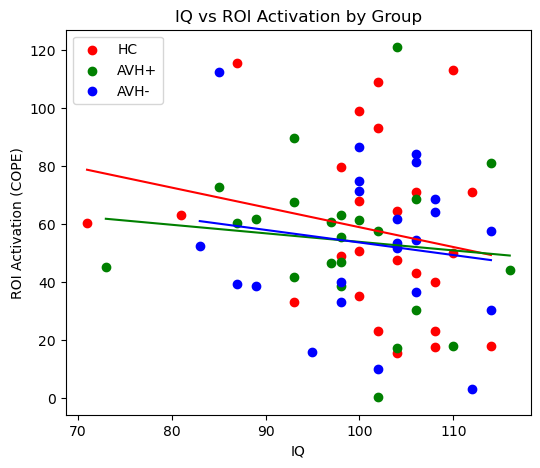

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe3_audit[merged_pe3_audit["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


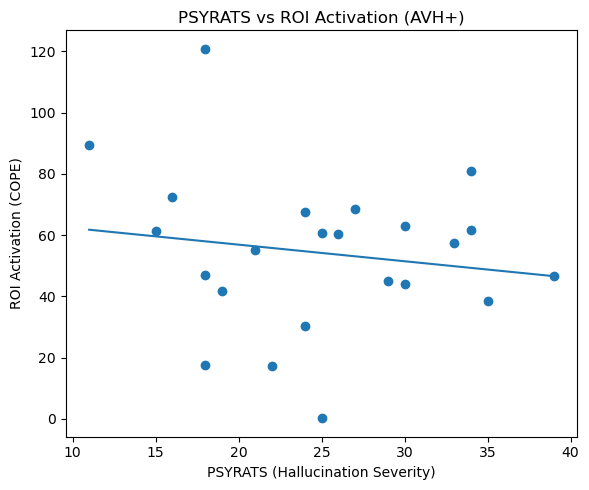

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = merged_pe3_audit.copy()

# keep AVH+ only (PSYRATS meaningful here)
df = df[df["group"] == "AVH+"].copy()

# clean columns
df["psyrats"] = pd.to_numeric(df["psyrats"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")

df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["psyrats", "roi_activation"])

# scatter plot
plt.figure(figsize=(6,5))
plt.scatter(df["psyrats"], df["roi_activation"])

# regression line
if len(df) >= 2 and df["psyrats"].nunique() >= 2:
    x = df["psyrats"].to_numpy()
    y = df["roi_activation"].to_numpy()
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, m*xs + b)

plt.xlabel("PSYRATS (Hallucination Severity)")
plt.ylabel("ROI Activation (COPE)")
plt.title("PSYRATS vs ROI Activation (AVH+)")
plt.tight_layout()
plt.show()


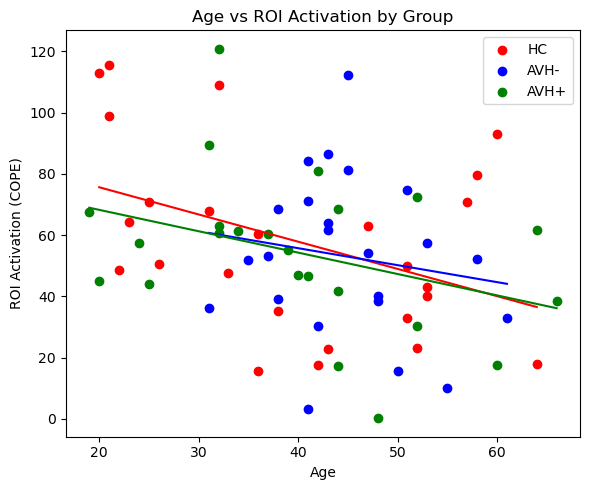

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = merged_pe3_audit.copy()

# clean columns
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["age", "roi_activation", "group"])

groups = {
    "HC": "red",
    "AVH-": "blue",
    "AVH+": "green"
}

plt.figure(figsize=(6,5))

for g, color in groups.items():
    subset = df[df["group"] == g]

    # scatter
    plt.scatter(
        subset["age"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line
    if len(subset) >= 2 and subset["age"].nunique() >= 2:
        x = subset["age"].to_numpy()
        y = subset["roi_activation"].to_numpy()
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m * xs + b, color=color)

plt.xlabel("Age")
plt.ylabel("ROI Activation (COPE)")
plt.title("Age vs ROI Activation by Group")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe5_audit = pd.read_csv(
    "roi_activation_audit_left_cope5.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe5_audit = participants.merge(
    pe5_audit,
    on="participant_id",
    how="inner"
)

merged_pe5_audit.to_csv("merged_pe5_audit.csv", index=False)

print(merged_pe5_audit.head())

  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       91.433466
1         sub-02   36    male  104    HC      NaN        4.954280
2         sub-03   43    male  108    HC      NaN       56.616962
3         sub-04   25    male  106    HC      NaN      148.040292
4         sub-05   52  female  102    HC      NaN       19.870517


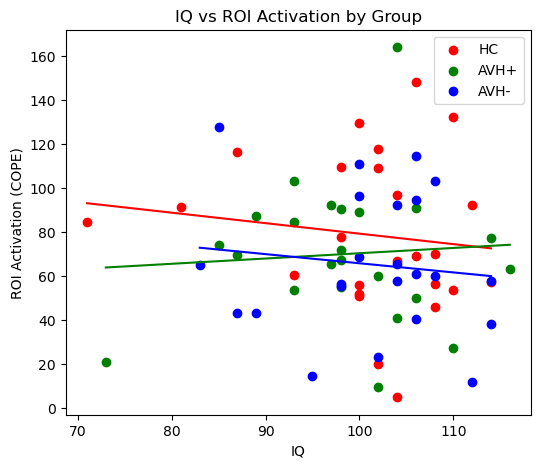

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe5_audit[merged_pe5_audit["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


HC: r = -0.131, p = 0.5326
AVH+: r = 0.073, p = 0.7410
AVH-: r = -0.114, p = 0.6061


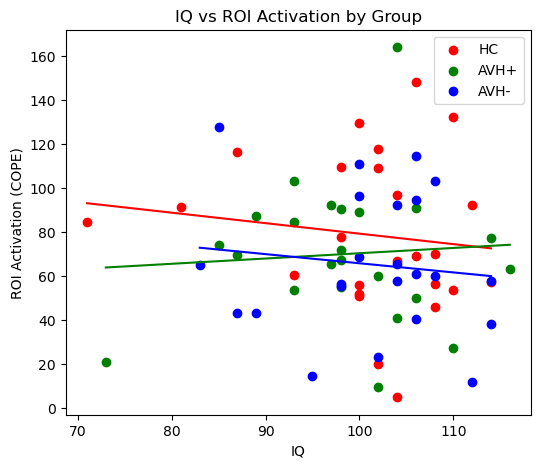

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe5_audit[merged_pe5_audit["group"] == g].copy()

    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    plt.scatter(subset["iq"], subset["roi_activation"], label=g, color=color)

    if len(subset) >= 3 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        # regression line
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

        # correlation
        r, p = pearsonr(x, y)
        print(f"{g}: r = {r:.3f}, p = {p:.4f}")

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


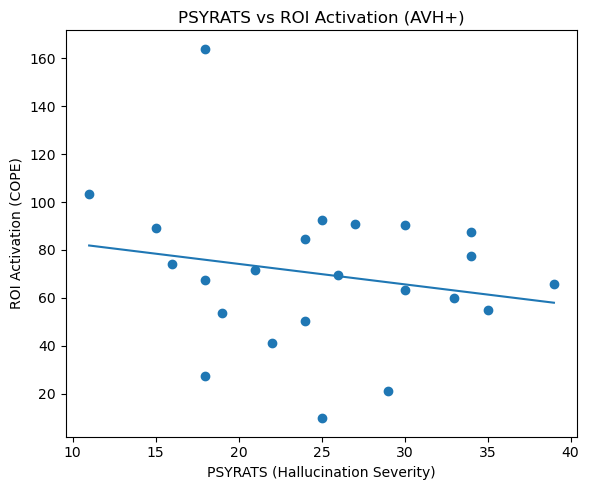

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = merged_pe5_audit.copy()

# keep AVH+ only (PSYRATS meaningful here)
df = df[df["group"] == "AVH+"].copy()

# clean columns
df["psyrats"] = pd.to_numeric(df["psyrats"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")

df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["psyrats", "roi_activation"])

# scatter plot
plt.figure(figsize=(6,5))
plt.scatter(df["psyrats"], df["roi_activation"])

# regression line
if len(df) >= 2 and df["psyrats"].nunique() >= 2:
    x = df["psyrats"].to_numpy()
    y = df["roi_activation"].to_numpy()
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, m*xs + b)

plt.xlabel("PSYRATS (Hallucination Severity)")
plt.ylabel("ROI Activation (COPE)")
plt.title("PSYRATS vs ROI Activation (AVH+)")
plt.tight_layout()
plt.show()


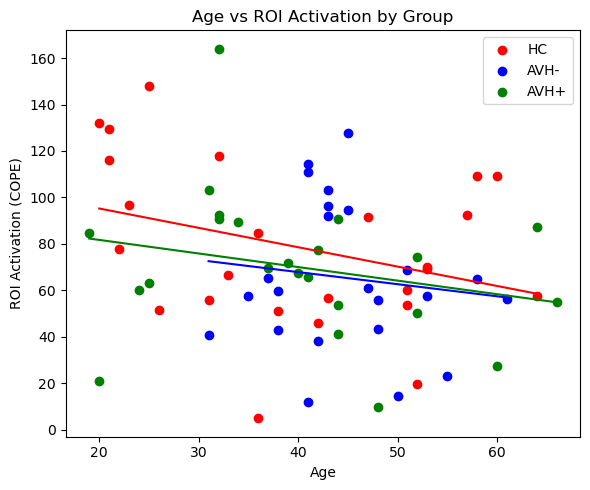

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = merged_pe5_audit.copy()

# clean columns
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["age", "roi_activation", "group"])

groups = {
    "HC": "red",
    "AVH-": "blue",
    "AVH+": "green"
}

plt.figure(figsize=(6,5))

for g, color in groups.items():
    subset = df[df["group"] == g]

    # scatter
    plt.scatter(
        subset["age"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line
    if len(subset) >= 2 and subset["age"].nunique() >= 2:
        x = subset["age"].to_numpy()
        y = subset["roi_activation"].to_numpy()
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m * xs + b, color=color)

plt.xlabel("Age")
plt.ylabel("ROI Activation (COPE)")
plt.title("Age vs ROI Activation by Group")
plt.legend()
plt.tight_layout()
plt.show()


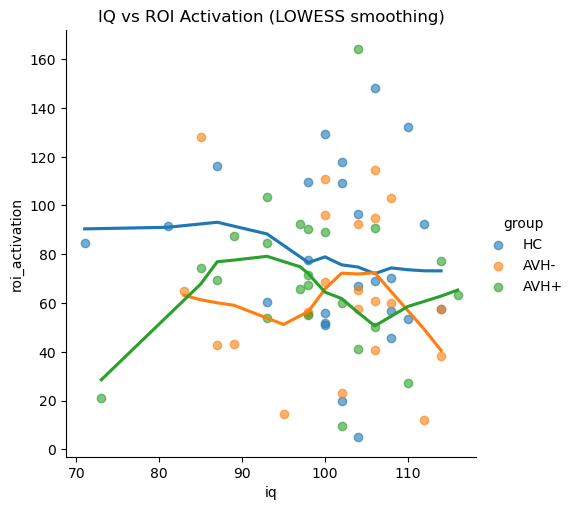

In [ ]:
import seaborn as sns

sns.lmplot(
    data=merged_pe5_audit,
    x="iq",
    y="roi_activation",
    hue="group",
    lowess=True,
    height=5,
    scatter_kws={"alpha":0.6}
)
plt.title("IQ vs ROI Activation (LOWESS smoothing)")
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/2253628217.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby("iq_bin")["roi_activation"].mean()
/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/2253628217.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = df.groupby("iq_bin")["iq"].mean()


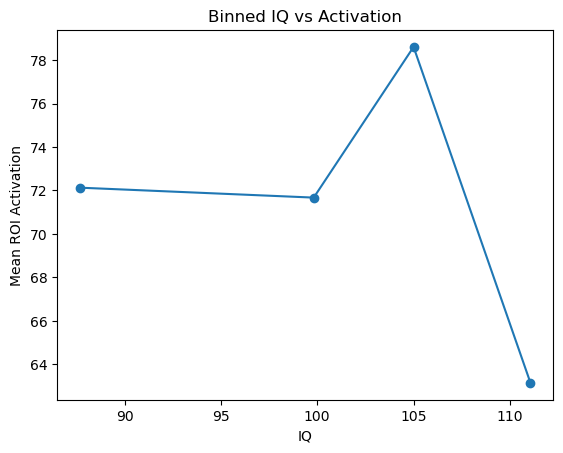

In [ ]:
df = merged_pe5_audit.copy()
df["iq_bin"] = pd.qcut(df["iq"], q=4)

means = df.groupby("iq_bin")["roi_activation"].mean()
centers = df.groupby("iq_bin")["iq"].mean()

plt.plot(centers, means, marker="o")
plt.xlabel("IQ")
plt.ylabel("Mean ROI Activation")
plt.title("Binned IQ vs Activation")
plt.show()


<Axes: xlabel='iq_bin', ylabel='roi_activation'>

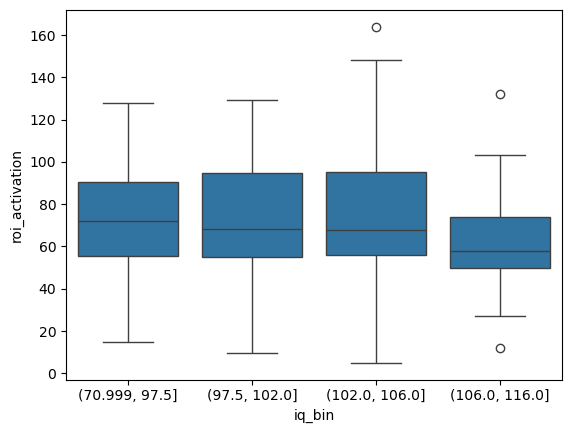

In [ ]:
sns.boxplot(
    data=df,
    x="iq_bin",
    y="roi_activation"
)


# Temporal Lobe

In [ ]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe1_temp = pd.read_csv(
    "roi_activation_temporal_cope1.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe1_temp = participants.merge(
    pe1_temp,
    on="participant_id",
    how="inner"
)

merged_pe1_temp.to_csv("merged_pe1_temp.csv", index=False)

print(merged_pe1_temp.head())


  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       21.661141
1         sub-02   36    male  104    HC      NaN       -4.667495
2         sub-03   43    male  108    HC      NaN       19.377081
3         sub-04   25    male  106    HC      NaN       40.751682
4         sub-05   52  female  102    HC      NaN       14.457272


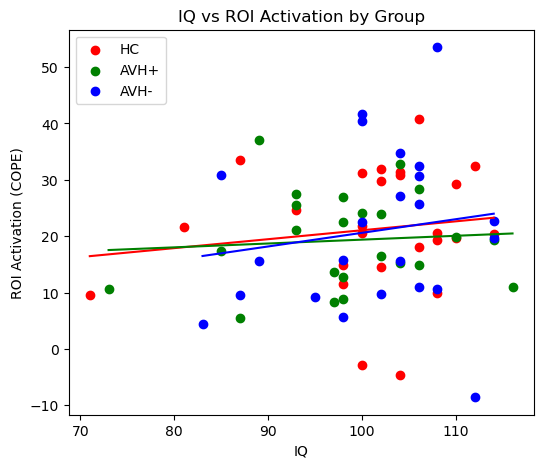

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe1_temp[merged_pe1_temp["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


In [ ]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe3_temp = pd.read_csv(
    "roi_activation_temporal_cope3.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe3_temp = participants.merge(
    pe3_temp,
    on="participant_id",
    how="inner"
)

merged_pe3_temp.to_csv("merged_pe3_temp.csv", index=False)

print(merged_pe3_temp.head())


  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       22.071351
1         sub-02   36    male  104    HC      NaN        3.660355
2         sub-03   43    male  108    HC      NaN        3.555235
3         sub-04   25    male  106    HC      NaN       21.924946
4         sub-05   52  female  102    HC      NaN       13.594142


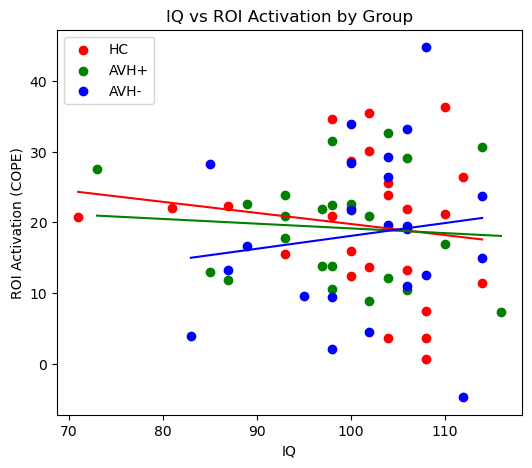

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe3_temp[merged_pe3_temp["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


In [ ]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe5_temp = pd.read_csv(
    "roi_activation_temporal_cope5.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe5_temp = participants.merge(
    pe5_temp,
    on="participant_id",
    how="inner"
)

merged_pe5_temp.to_csv("merged_pe5_temp.csv", index=False)

print(merged_pe5_temp.head())


  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       38.606302
1         sub-02   36    male  104    HC      NaN       -2.966201
2         sub-03   43    male  108    HC      NaN       25.835431
3         sub-04   25    male  106    HC      NaN       41.846942
4         sub-05   52  female  102    HC      NaN       15.039170


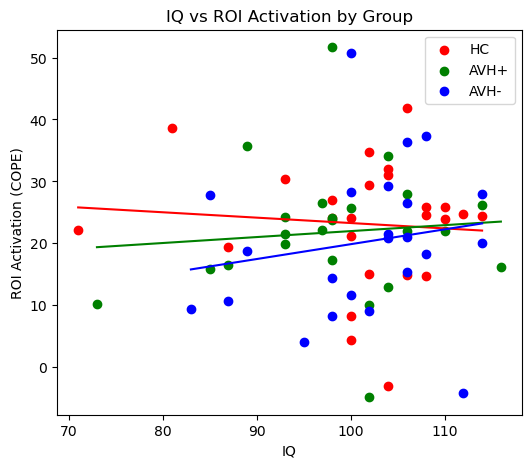

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe5_temp[merged_pe5_temp["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = merged_pe5_audit.copy()

df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# create quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=4, labels=["Q1","Q2","Q3","Q4"])

# keep only lowest and highest quartiles
df_extreme = df[df["iq_quartile"].isin(["Q1","Q4"])].copy()

# rename for clarity
df_extreme["IQ_group"] = df_extreme["iq_quartile"].replace({
    "Q1": "Low IQ",
    "Q4": "High IQ"
})


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/949976361.py:18: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_extreme["IQ_group"] = df_extreme["iq_quartile"].replace({


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/3354227238.py:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


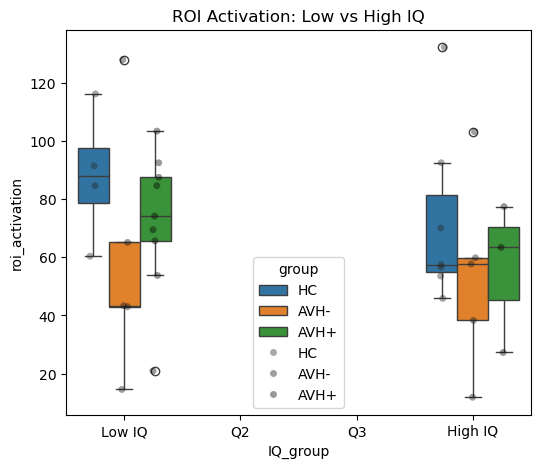

In [ ]:
plt.figure(figsize=(6,5))

sns.boxplot(
    data=df_extreme,
    x="IQ_group",
    y="roi_activation",
    hue="group"
)

sns.stripplot(
    data=df_extreme,
    x="IQ_group",
    y="roi_activation",
    hue="group",
    dodge=True,
    alpha=0.4,
    color="black"
)

plt.title("ROI Activation: Low vs High IQ")
plt.show()


In [ ]:
from scipy.stats import ttest_ind

low = df_extreme[df_extreme["IQ_group"] == "Low IQ"]["roi_activation"]
high = df_extreme[df_extreme["IQ_group"] == "High IQ"]["roi_activation"]

t, p = ttest_ind(low, high)
print("t =", t, "p =", p)


t = 0.8540670839404809 p = 0.39961975802612637


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/1653309393.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = subset.groupby("iq_quartile")["roi_activation"].mean()
/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/1653309393.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = subset.groupby("iq_quartile")["roi_activation"].sem()


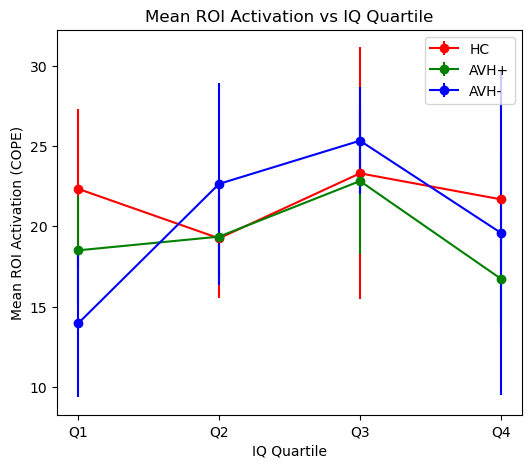

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = merged_pe1_temp.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# create quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=4, labels=["Q1","Q2","Q3","Q4"])

plt.figure(figsize=(6,5))

for g, color in {"HC":"red","AVH+":"green","AVH-":"blue"}.items():
    subset = df[df["group"] == g]

    means = subset.groupby("iq_quartile")["roi_activation"].mean()
    sems = subset.groupby("iq_quartile")["roi_activation"].sem()

    plt.errorbar(
        means.index,
        means.values,
        yerr=sems.values,
        marker="o",
        label=g,
        color=color
    )

plt.xlabel("IQ Quartile")
plt.ylabel("Mean ROI Activation (COPE)")
plt.title("Mean ROI Activation vs IQ Quartile")
plt.legend()
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/749909208.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = subset.groupby("iq_quartile")["roi_activation"].mean()
/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/749909208.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = subset.groupby("iq_quartile")["roi_activation"].sem()


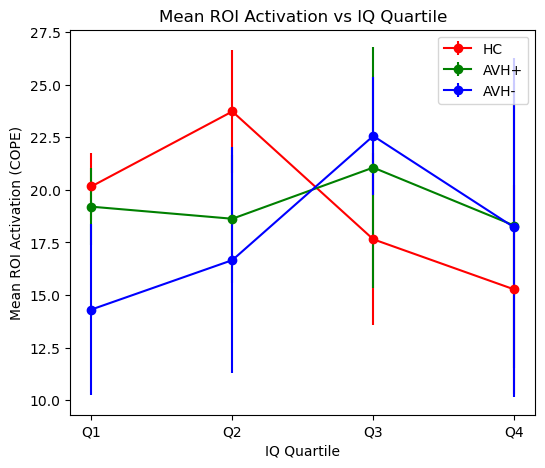

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = merged_pe3_temp.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# create quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=4, labels=["Q1","Q2","Q3","Q4"])

plt.figure(figsize=(6,5))

for g, color in {"HC":"red","AVH+":"green","AVH-":"blue"}.items():
    subset = df[df["group"] == g]

    means = subset.groupby("iq_quartile")["roi_activation"].mean()
    sems = subset.groupby("iq_quartile")["roi_activation"].sem()

    plt.errorbar(
        means.index,
        means.values,
        yerr=sems.values,
        marker="o",
        label=g,
        color=color
    )

plt.xlabel("IQ Quartile")
plt.ylabel("Mean ROI Activation (COPE)")
plt.title("Mean ROI Activation vs IQ Quartile")
plt.legend()
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/429427350.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = subset.groupby("iq_quartile")["roi_activation"].mean()
/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/429427350.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = subset.groupby("iq_quartile")["roi_activation"].sem()


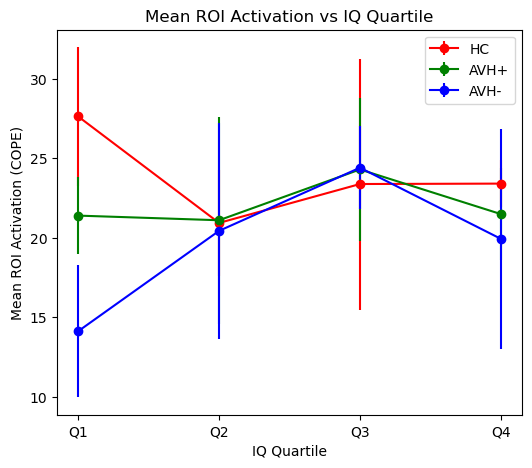

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = merged_pe5_temp.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# create quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=4, labels=["Q1","Q2","Q3","Q4"])

plt.figure(figsize=(6,5))

for g, color in {"HC":"red","AVH+":"green","AVH-":"blue"}.items():
    subset = df[df["group"] == g]

    means = subset.groupby("iq_quartile")["roi_activation"].mean()
    sems = subset.groupby("iq_quartile")["roi_activation"].sem()

    plt.errorbar(
        means.index,
        means.values,
        yerr=sems.values,
        marker="o",
        label=g,
        color=color
    )

plt.xlabel("IQ Quartile")
plt.ylabel("Mean ROI Activation (COPE)")
plt.title("Mean ROI Activation vs IQ Quartile")
plt.legend()
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/242693366.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = subset.groupby("iq_quartile")["roi_activation"].mean()
/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/242693366.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = subset.groupby("iq_quartile")["roi_activation"].sem()


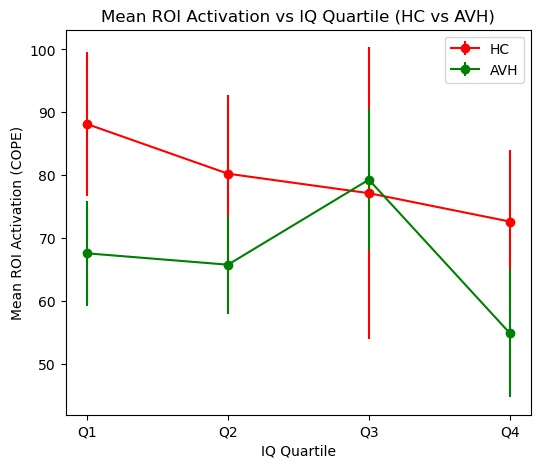

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = merged_pe5_audit.copy()

# clean data
df["iq"] = pd.to_numeric(df["iq"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["iq", "roi_activation"])

# combine groups
df["group_combined"] = df["group"].replace({
    "AVH+": "AVH",
    "AVH-": "AVH"
})

# create quartiles
df["iq_quartile"] = pd.qcut(df["iq"], q=4, labels=["Q1","Q2","Q3","Q4"])

plt.figure(figsize=(6,5))

for g, color in {"HC":"red", "AVH":"green"}.items():
    subset = df[df["group_combined"] == g]

    means = subset.groupby("iq_quartile")["roi_activation"].mean()
    sems = subset.groupby("iq_quartile")["roi_activation"].sem()

    plt.errorbar(
        means.index,
        means.values,
        yerr=sems.values,
        marker="o",
        label=g,
        color=color
    )

plt.xlabel("IQ Quartile")
plt.ylabel("Mean ROI Activation (COPE)")
plt.title("Mean ROI Activation vs IQ Quartile (HC vs AVH)")
plt.legend()
plt.show()


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_67325/3633360513.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sex_levels, showfliers=False)


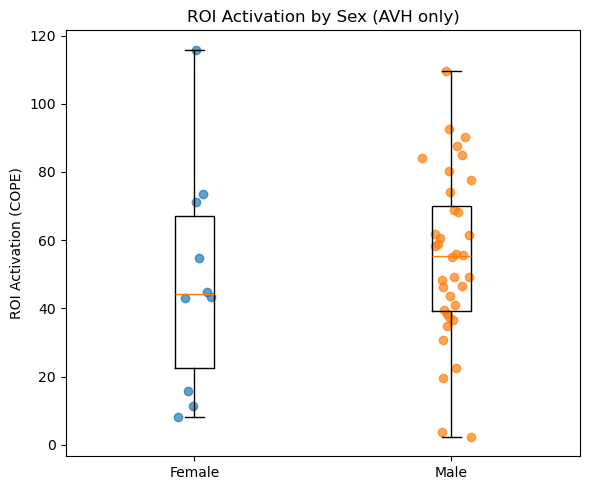

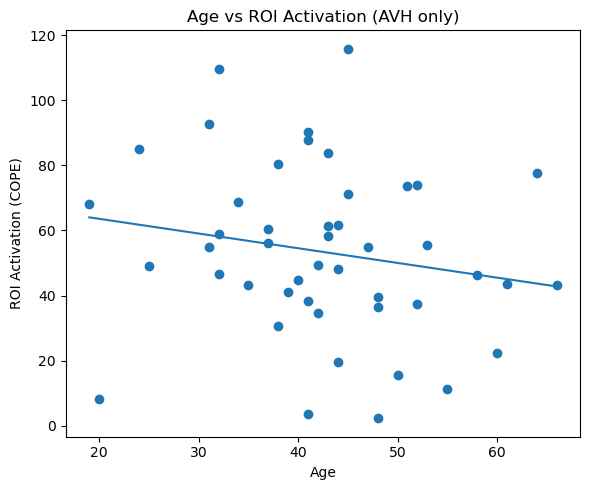

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = merged_pe1_audit.copy()

# keep only AVH subjects
df = df[df["group"].isin(["AVH+", "AVH-"])]

# clean columns
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["sex"] = df["sex"].astype(str).str.strip()

df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["roi_activation", "age", "sex"])

# normalize sex labels
sex_norm = df["sex"].str.lower()
df["sex_norm"] = np.where(sex_norm.str.startswith("f"), "Female",
                   np.where(sex_norm.str.startswith("m"), "Male", df["sex"]))

# -------------------------
# 1) SEX vs ACTIVATION
# -------------------------
plt.figure(figsize=(6,5))

sex_levels = sorted(df["sex_norm"].unique())
data = [df[df["sex_norm"] == s]["roi_activation"] for s in sex_levels]

plt.boxplot(data, labels=sex_levels, showfliers=False)

# jitter points
rng = np.random.default_rng(0)
for i, s in enumerate(sex_levels):
    y = df[df["sex_norm"] == s]["roi_activation"].to_numpy()
    x = rng.normal(i + 1, 0.05, size=len(y))
    plt.scatter(x, y, alpha=0.7)

plt.ylabel("ROI Activation (COPE)")
plt.title("ROI Activation by Sex (AVH only)")
plt.tight_layout()
plt.show()


# -------------------------
# 2) AGE vs ACTIVATION
# -------------------------
plt.figure(figsize=(6,5))

plt.scatter(df["age"], df["roi_activation"])

# regression line
if len(df) >= 2 and df["age"].nunique() >= 2:
    x = df["age"].to_numpy()
    y = df["roi_activation"].to_numpy()
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, m*xs + b)

plt.xlabel("Age")
plt.ylabel("ROI Activation (COPE)")
plt.title("Age vs ROI Activation (AVH only)")
plt.tight_layout()
plt.show()


# Heschl Gyrus

## Sentences

In [81]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe1_heschl = pd.read_csv(
    "roi_activation_heschl_cope1.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe1_heschl = participants.merge(
    pe1_heschl,
    on="participant_id",
    how="inner"
)

merged_pe1_heschl.to_csv("merged_pe1_heschl.csv", index=False)

print(merged_pe1_heschl.head())


  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       46.134443
1         sub-02   36    male  104    HC      NaN        7.790374
2         sub-03   43    male  108    HC      NaN       48.762609
3         sub-04   25    male  106    HC      NaN      126.366131
4         sub-05   52  female  102    HC      NaN       19.919390


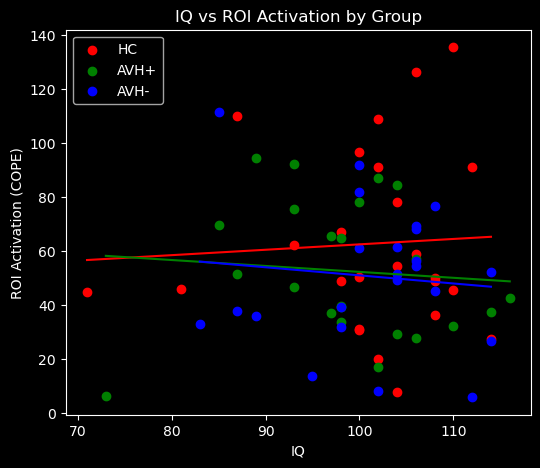

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe1_heschl[merged_pe1_heschl["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


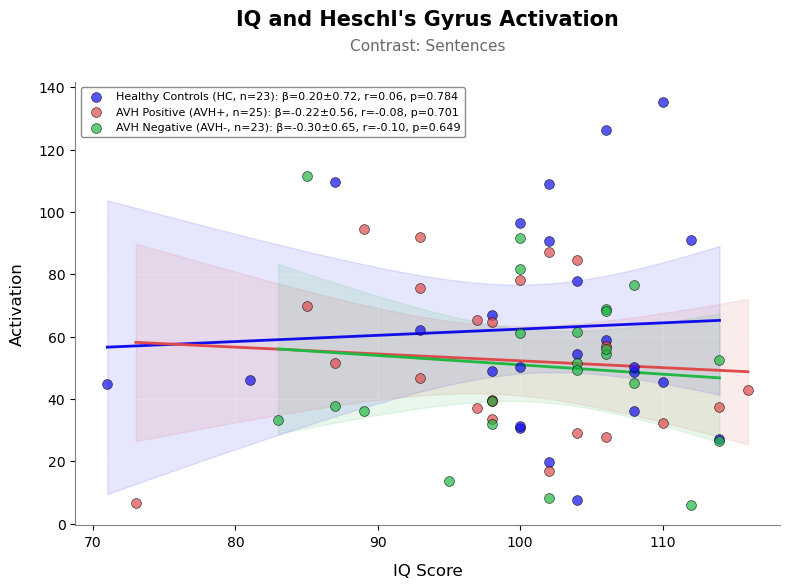

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

groups = {
    "HC":   {"color": "#110eec", "label": "Healthy Controls"},
    "AVH+": {"color": "#de4a4a", "label": "AVH Positive"},
    "AVH-": {"color": "#20b743", "label": "AVH Negative"},
}

for g, conf in groups.items():
    subset = merged_pe1_heschl[merged_pe1_heschl["group"] == g].copy()
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    if len(subset) < 3 or subset["iq"].nunique() < 2:
        continue

    x = subset["iq"].to_numpy()
    y = subset["roi_activation"].to_numpy()

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    ax.scatter(x, y, color=conf["color"], alpha=0.7, s=50, edgecolors='black',
               linewidths=0.5, zorder=3,
               label=f'{conf["label"]} ({g}, n={n}): β={slope:.2f}±{std_err:.2f}, r={r_value:.2f}, p={p_value:.3f}')

    xs = np.linspace(x.min(), x.max(), 200)
    y_hat = slope * xs + intercept

    n = len(x)
    x_mean = x.mean()
    se_fit = np.sqrt(
        (np.sum((y - (slope*x + intercept))**2) / (n - 2))
        * (1/n + (xs - x_mean)**2 / np.sum((x - x_mean)**2))
    )
    t_crit = stats.t.ppf(0.975, df=n-2)

    ax.fill_between(xs, y_hat - t_crit*se_fit, y_hat + t_crit*se_fit,
                     color=conf["color"], alpha=0.1, zorder=1)
    ax.plot(xs, y_hat, color=conf["color"], linewidth=2, zorder=2)

ax.set_xlabel("IQ Score", fontsize=12, color='black', labelpad=10)
ax.set_ylabel("Activation", fontsize=12, color='black', labelpad=10)
ax.set_title("IQ and Heschl's Gyrus Activation", fontsize=15, color='black', pad=15, fontweight='bold', y=1.08)
ax.text(
    0.5, 1.07,
    "Contrast: Sentences",
    transform=ax.transAxes,
    ha="center",
    fontsize=11,
    color="dimgray"
)

ax.tick_params(colors='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.grid(True, alpha=0.15)

legend = ax.legend(fontsize=8, loc='upper left', frameon=True, facecolor='white',
                   edgecolor='gray', framealpha=0.9)
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.savefig("iq_vs_roi_scatter.png", dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Words

In [88]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe3_heschl = pd.read_csv(
    "roi_activation_heschl_cope3.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe3_heschl = participants.merge(
    pe3_heschl,
    on="participant_id",
    how="inner"
)

merged_pe3_heschl.to_csv("merged_pe3_heschl.csv", index=False)

print(merged_pe3_heschl.head())


  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       48.999355
1         sub-02   36    male  104    HC      NaN        6.648621
2         sub-03   43    male  108    HC      NaN       27.006705
3         sub-04   25    male  106    HC      NaN       78.486881
4         sub-05   52  female  102    HC      NaN       29.141263


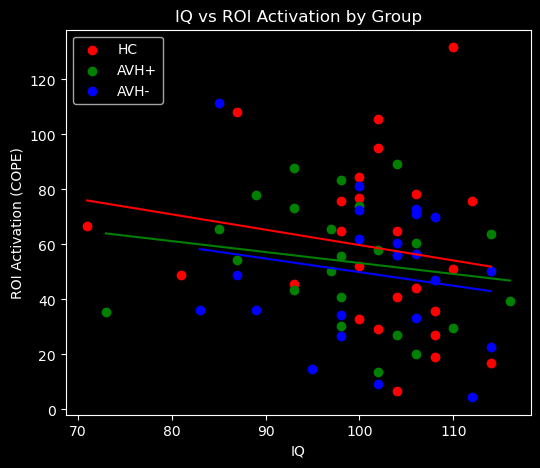

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe3_heschl[merged_pe3_heschl["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


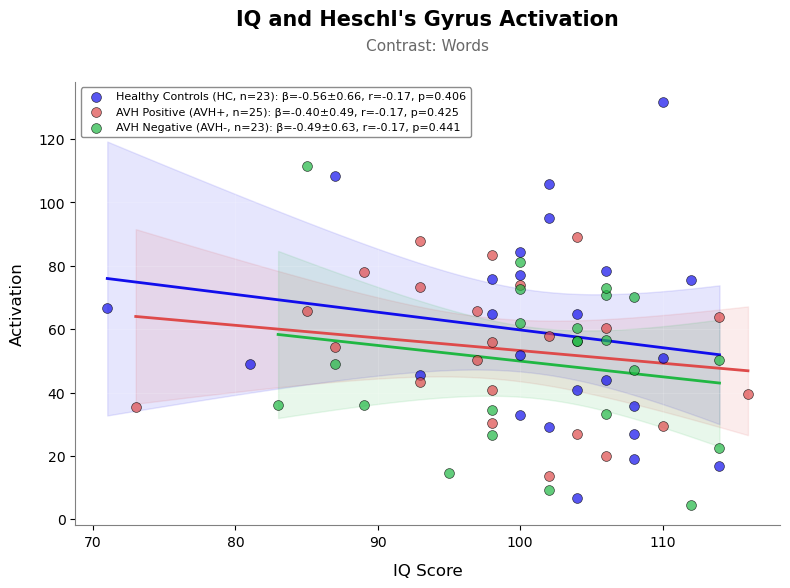

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

groups = {
    "HC":   {"color": "#110eec", "label": "Healthy Controls"},
    "AVH+": {"color": "#de4a4a", "label": "AVH Positive"},
    "AVH-": {"color": "#20b743", "label": "AVH Negative"},
}

for g, conf in groups.items():
    subset = merged_pe3_heschl[merged_pe3_heschl["group"] == g].copy()
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    if len(subset) < 3 or subset["iq"].nunique() < 2:
        continue

    x = subset["iq"].to_numpy()
    y = subset["roi_activation"].to_numpy()

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    ax.scatter(x, y, color=conf["color"], alpha=0.7, s=50, edgecolors='black',
               linewidths=0.5, zorder=3,
               label=f'{conf["label"]} ({g}, n={n}): β={slope:.2f}±{std_err:.2f}, r={r_value:.2f}, p={p_value:.3f}')

    xs = np.linspace(x.min(), x.max(), 200)
    y_hat = slope * xs + intercept

    n = len(x)
    x_mean = x.mean()
    se_fit = np.sqrt(
        (np.sum((y - (slope*x + intercept))**2) / (n - 2))
        * (1/n + (xs - x_mean)**2 / np.sum((x - x_mean)**2))
    )
    t_crit = stats.t.ppf(0.975, df=n-2)

    ax.fill_between(xs, y_hat - t_crit*se_fit, y_hat + t_crit*se_fit,
                     color=conf["color"], alpha=0.1, zorder=1)
    ax.plot(xs, y_hat, color=conf["color"], linewidth=2, zorder=2)

ax.set_xlabel("IQ Score", fontsize=12, color='black', labelpad=10)
ax.set_ylabel("Activation", fontsize=12, color='black', labelpad=10)
ax.set_title("IQ and Heschl's Gyrus Activation", fontsize=15, color='black', pad=15, fontweight='bold', y=1.08)
ax.text(
    0.5, 1.07,
    "Contrast: Words",
    transform=ax.transAxes,
    ha="center",
    fontsize=11,
    color="dimgray"
)

ax.tick_params(colors='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.grid(True, alpha=0.15)

legend = ax.legend(fontsize=8, loc='upper left', frameon=True, facecolor='white',
                   edgecolor='gray', framealpha=0.9)
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.savefig("iq_vs_roi_scatter.png", dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

In [91]:
import pandas as pd

participants = pd.read_csv("participants.csv")
pe5_heschl = pd.read_csv(
    "roi_activation_heschl_cope5.csv",
    header=None,
    names=["participant_id", "roi_activation"]
)

merged_pe5_heschl = participants.merge(
    pe5_heschl,
    on="participant_id",
    how="inner"
)

merged_pe5_heschl.to_csv("merged_pe5_heschl.csv", index=False)

print(merged_pe5_heschl.head())


  participant_id  age     sex   iq group  psyrats  roi_activation
0         sub-01   47    male   81    HC      NaN       82.937239
1         sub-02   36    male  104    HC      NaN       -0.959193
2         sub-03   43    male  108    HC      NaN       58.386873
3         sub-04   25    male  106    HC      NaN      139.755548
4         sub-05   52  female  102    HC      NaN       31.641256


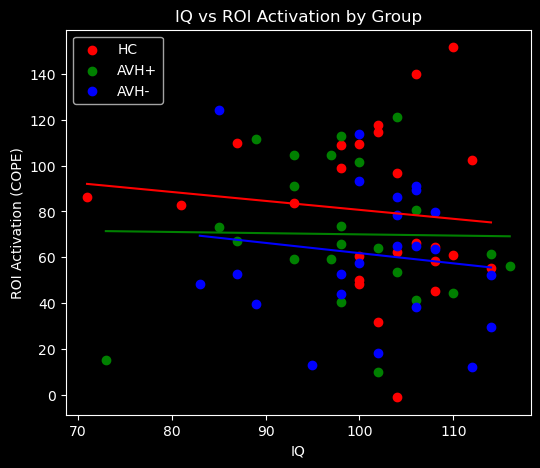

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(6, 5))

groups = {
    "HC": "red",
    "AVH+": "green",
    "AVH-": "blue"
}

for g, color in groups.items():
    subset = merged_pe5_heschl[merged_pe5_heschl["group"] == g].copy()

    # force numeric and drop bad rows
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    # scatter (only valid points)
    plt.scatter(
        subset["iq"],
        subset["roi_activation"],
        label=g,
        color=color
    )

    # regression line (need at least 2 unique x values)
    if len(subset) >= 2 and subset["iq"].nunique() >= 2:
        x = subset["iq"].to_numpy()
        y = subset["roi_activation"].to_numpy()

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m*xs + b, color=color)

plt.xlabel("IQ")
plt.ylabel("ROI Activation (COPE)")
plt.title("IQ vs ROI Activation by Group")
plt.legend()
plt.show()


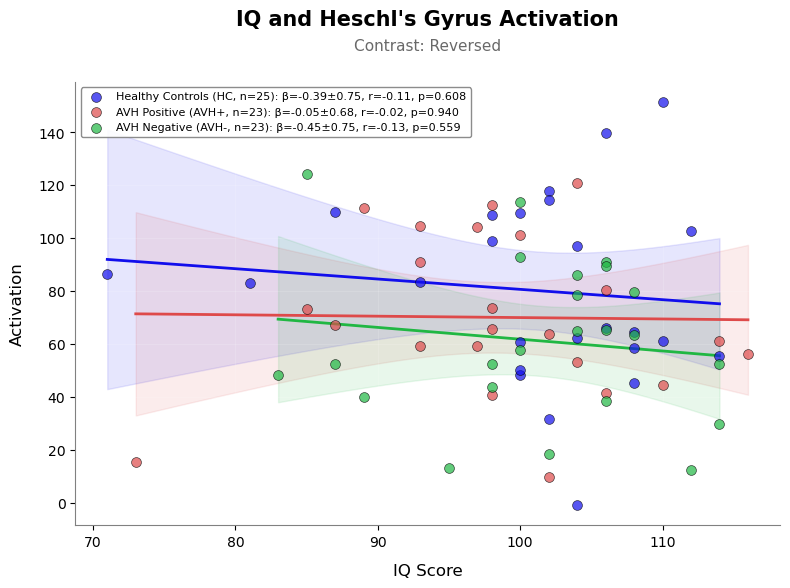

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

groups = {
    "HC":   {"color": "#110eec", "label": "Healthy Controls"},
    "AVH+": {"color": "#de4a4a", "label": "AVH Positive"},
    "AVH-": {"color": "#20b743", "label": "AVH Negative"},
}

for g, conf in groups.items():
    subset = merged_pe5_heschl[merged_pe5_heschl["group"] == g].copy()
    subset["iq"] = pd.to_numeric(subset["iq"], errors="coerce")
    subset["roi_activation"] = pd.to_numeric(subset["roi_activation"], errors="coerce")
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=["iq", "roi_activation"])

    if len(subset) < 3 or subset["iq"].nunique() < 2:
        continue

    x = subset["iq"].to_numpy()
    y = subset["roi_activation"].to_numpy()
    n = len(x)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    ax.scatter(x, y, color=conf["color"], alpha=0.7, s=50, edgecolors='black',
               linewidths=0.5, zorder=3,
               label=f'{conf["label"]} ({g}, n={n}): β={slope:.2f}±{std_err:.2f}, r={r_value:.2f}, p={p_value:.3f}')

    xs = np.linspace(x.min(), x.max(), 200)
    y_hat = slope * xs + intercept

    
    x_mean = x.mean()
    se_fit = np.sqrt(
        (np.sum((y - (slope*x + intercept))**2) / (n - 2))
        * (1/n + (xs - x_mean)**2 / np.sum((x - x_mean)**2))
    )
    t_crit = stats.t.ppf(0.975, df=n-2)

    ax.fill_between(xs, y_hat - t_crit*se_fit, y_hat + t_crit*se_fit,
                     color=conf["color"], alpha=0.1, zorder=1)
    ax.plot(xs, y_hat, color=conf["color"], linewidth=2, zorder=2)

ax.set_xlabel("IQ Score", fontsize=12, color='black', labelpad=10)
ax.set_ylabel("Activation", fontsize=12, color='black', labelpad=10)
ax.set_title("IQ and Heschl's Gyrus Activation", fontsize=15, color='black', pad=15, fontweight='bold', y=1.08)
ax.text(
    0.5, 1.07,
    "Contrast: Reversed",
    transform=ax.transAxes,
    ha="center",
    fontsize=11,
    color="dimgray"
)

ax.tick_params(colors='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.grid(True, alpha=0.15)

legend = ax.legend(fontsize=8, loc='upper left', frameon=True, facecolor='white',
                   edgecolor='gray', framealpha=0.9)
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.savefig("iq_vs_roi_scatter.png", dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

In [96]:
from scipy.stats import pearsonr
import pandas as pd

df = merged_pe5_heschl.copy()

# combine AVH+ and AVH-
df["group_combined"] = df["group"].replace({
    "AVH+": "AVH",
    "AVH-": "AVH"
})

# clean
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["roi_activation"] = pd.to_numeric(df["roi_activation"], errors="coerce")
df = df.dropna(subset=["age","roi_activation","group_combined"])

for g in ["HC", "AVH"]:
    sub = df[df["group_combined"] == g]

    if len(sub) >= 3:
        r, p = pearsonr(sub["age"], sub["roi_activation"])
        print(f"{g}: r = {r:.3f}, p = {p:.4f}, n = {len(sub)}")


HC: r = -0.299, p = 0.1471, n = 25
AVH: r = -0.242, p = 0.1056, n = 46
